# Alpaca Hum Segmentation – Benchmark Insights

**Notebook goal** – Load `metrics.csv` produced by `evaluate_benchmark.py`,
visualise and compare model variants across thresholds:

* Overall leaderboard (F1, precision, recall)
* F1 vs. classification threshold curves for each model
* Precision–Recall scatter
* Boundary‐error (Δstart/Δend) distribution
* Call‐rate correlation (Pearson vs. Spearman)
* Q1‐only recall heat‑map

In [26]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [27]:
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/BENCHMARK/metrics.csv")  # adjust if saved elsewhere
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [28]:
df = pd.read_csv(METRICS_CSV)

def parse_variant_tag(tag: str):
    """return seq_len (ms), hop (ms), threshold (float)"""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to s
    hop = int(m[2]) / 1000
    th = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

In [29]:
leader_cols = [
    "model",
    "variant",
    "precision",
    "recall",
    "f1",
    "mean_dstart_ms",
    "mean_dend_ms",
]
leader = df[leader_cols].sort_values("f1", ascending=False)
leader.head(20)

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
6,v3_tape_proportional,len400_hop050_th90,0.100873,0.574586,0.171617,189.173077,137.750000
3,v3_tape_proportional,len400_hop050_th80,0.055523,0.530387,0.100524,224.135417,165.614583
7,v3_tape_proportional,len400_hop050_th70,0.033191,0.513812,0.062353,226.322581,181.462366
15,v2_quality,len400_hop050_th90,0.021066,0.375691,0.039894,230.602941,254.720588
1,v3_tape_proportional,len400_hop050_th60,0.020763,0.475138,0.039787,230.953488,196.104651
0,v3_tape_proportional,len400_hop050_th50,0.014412,0.441989,0.027913,235.575000,202.662500
8,v3_tape_proportional,len400_hop050_th40,0.010438,0.403315,0.020348,240.205479,218.753425
12,v2_quality,len400_hop050_th80,0.008912,0.309392,0.017324,252.928571,261.357143
5,v3_tape_proportional,len400_hop050_th30,0.007844,0.364641,0.015358,244.924242,223.560606
24,v1_random,len400_hop050_th90,0.007172,0.314917,0.014024,285.175439,253.175439


### Recall vs. threshold for each model

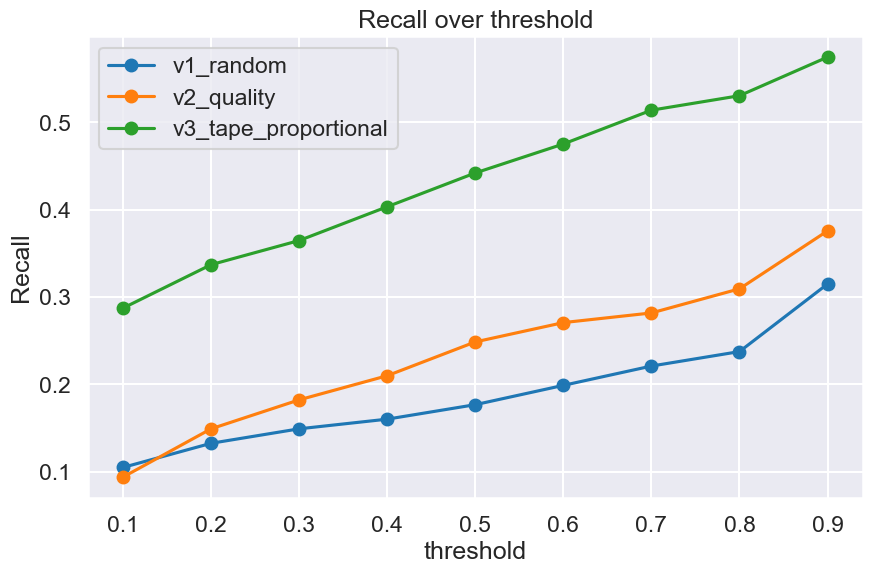

In [30]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["recall"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("Recall")
plt.title("Recall over threshold")
plt.legend()
plt.grid(True)
plt.show()

## Recall vs. threshold for each quality (Q1–Q3)

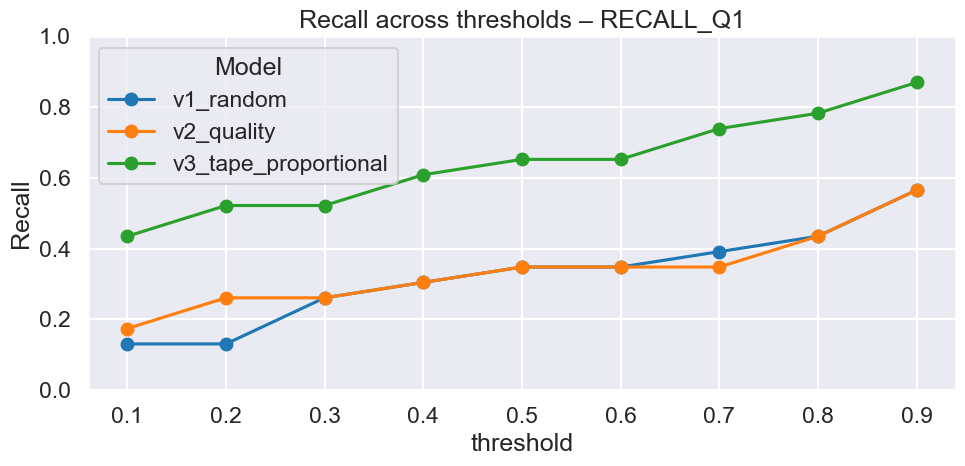

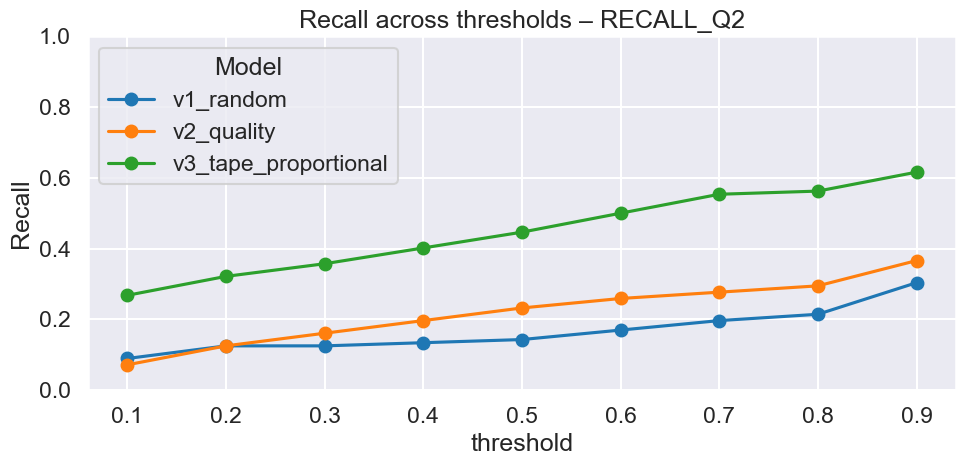

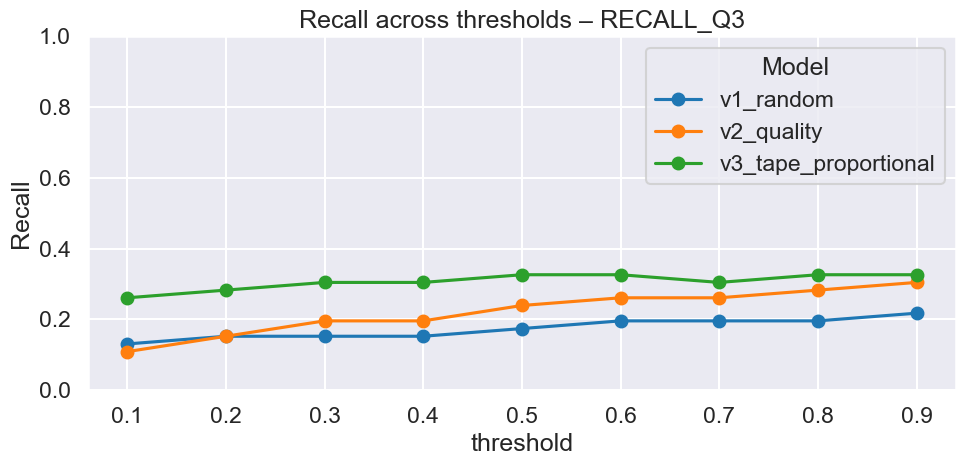

In [31]:
qualities = ["recall_q1", "recall_q2", "recall_q3"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 5))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.title(f"Recall across thresholds – {q.upper()}")
        plt.xlabel("threshold")
        plt.ylabel("Recall")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Detected calls vs. threshold (log scale)

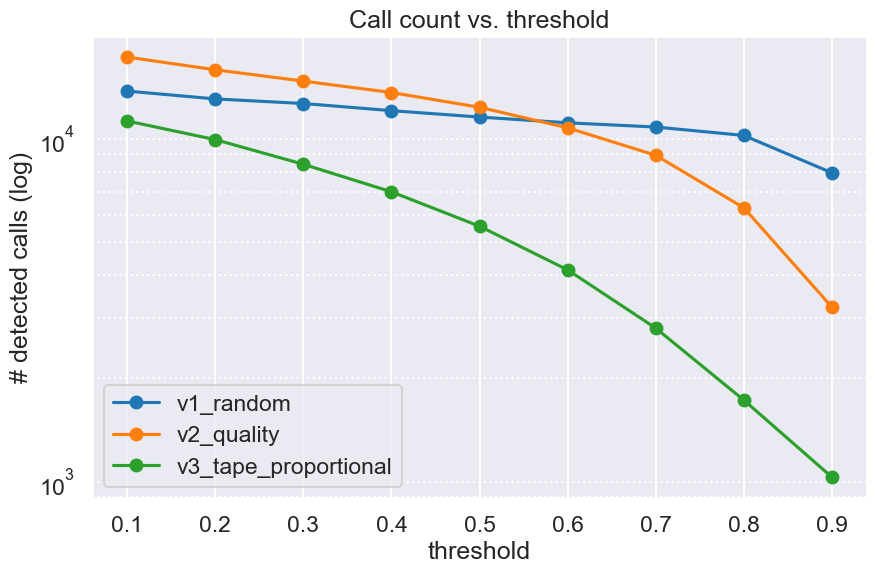

In [32]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["n_pred"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("# detected calls (log)")
plt.yscale("log")
plt.title("Call count vs. threshold")
plt.legend()
plt.grid(True, which="both", axis="y", linestyle=":")
plt.show()

### Top‑5 variants by F1

In [33]:
leader.head(5).style.format({"precision": "{:.2%}", "recall": "{:.2%}", "f1": "{:.2%}"})

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
6,v3_tape_proportional,len400_hop050_th90,10.09%,57.46%,17.16%,189.173077,137.750000
3,v3_tape_proportional,len400_hop050_th80,5.55%,53.04%,10.05%,224.135417,165.614583
7,v3_tape_proportional,len400_hop050_th70,3.32%,51.38%,6.24%,226.322581,181.462366
15,v2_quality,len400_hop050_th90,2.11%,37.57%,3.99%,230.602941,254.720588
1,v3_tape_proportional,len400_hop050_th60,2.08%,47.51%,3.98%,230.953488,196.104651


### F1 vs. threshold curve for each model

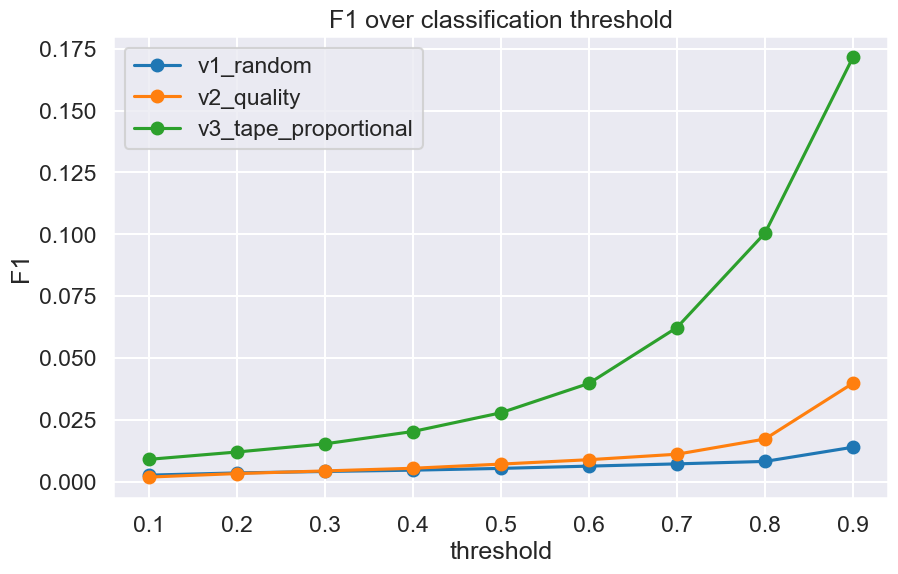

In [34]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["f1"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("F1")
plt.title("F1 over classification threshold")
plt.legend()
plt.grid(True)
plt.show()

### F1 per quality level (Q1–Q3) across thresholds

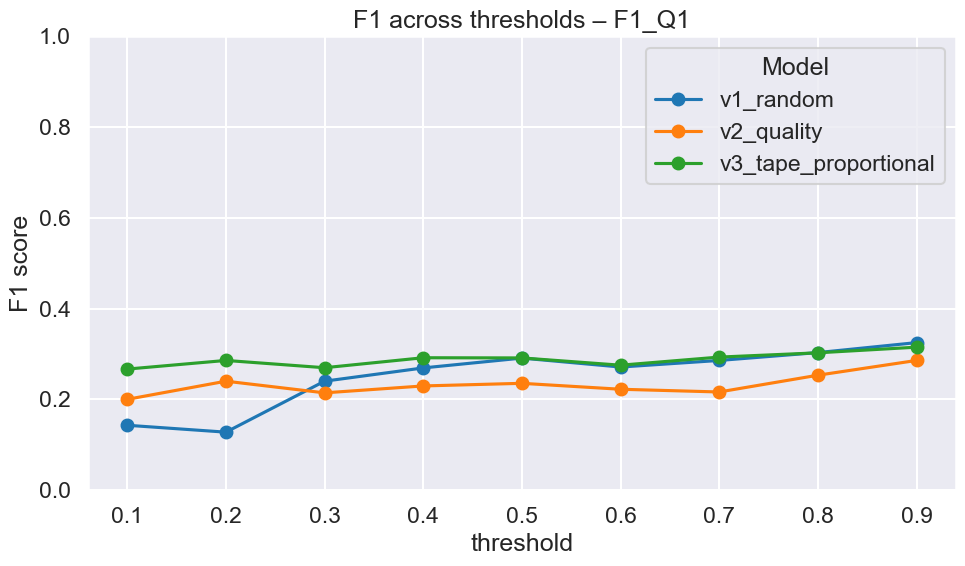

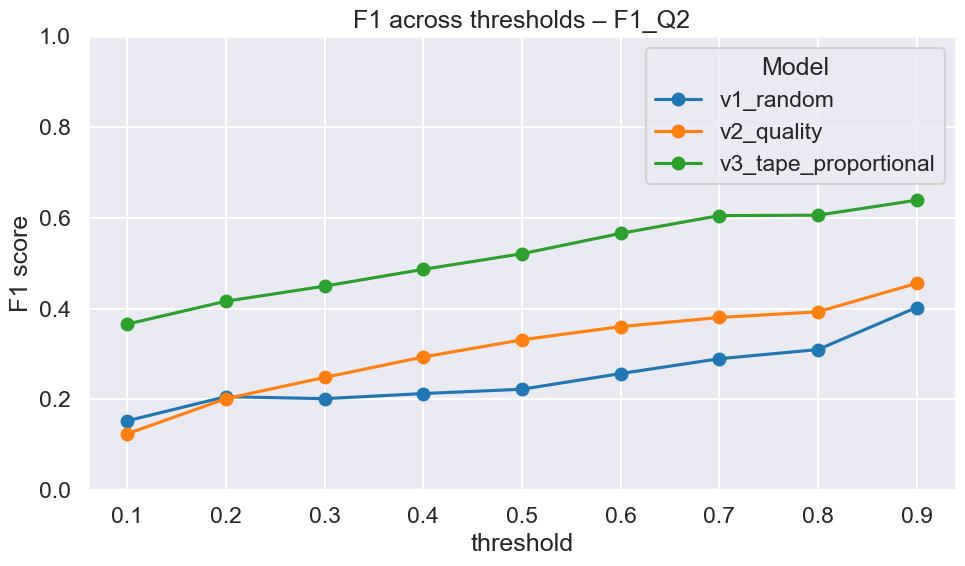

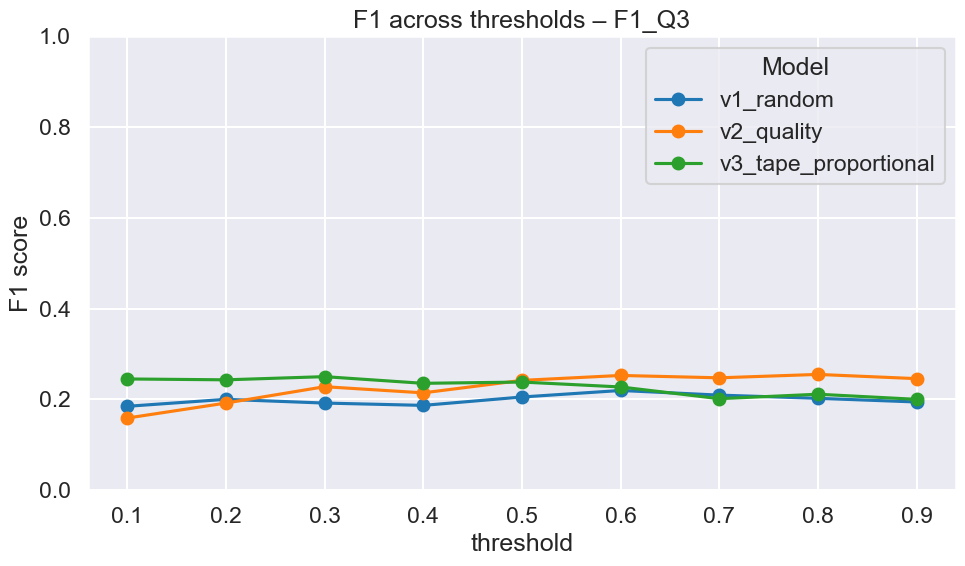

In [35]:
qualities = ["f1_q1", "f1_q2", "f1_q3"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 6))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.xlabel("threshold")
        plt.ylabel("F1 score")
        plt.title(f"F1 across thresholds – {q.upper()}")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Precision vs. Recall scatter

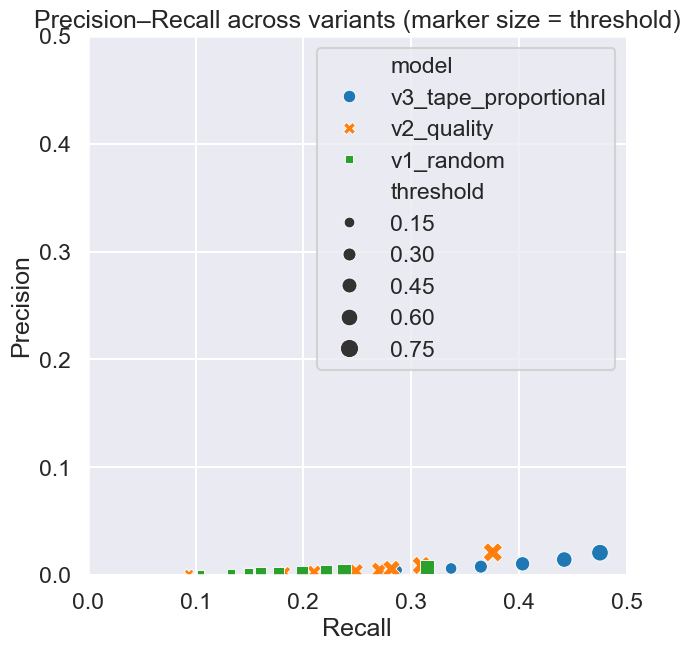

In [36]:
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(
    data=df,
    x="recall",
    y="precision",
    hue="model",
    style="model",
    size="threshold",
    sizes=(50, 200),
)
ax.set(xlim=(0, 0.5), ylim=(0, 0.5), xlabel="Recall", ylabel="Precision")
ax.set_aspect("equal")
plt.title("Precision–Recall across variants (marker size = threshold)")
plt.grid(True)
plt.show()

### Boundary error distributions

/var/folders/yy/mfzpfh1n7vsdd7qnk0wl69700000gn/T/ipykernel_69320/90596929.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/yy/mfzpfh1n7vsdd7qnk0wl69700000gn/T/ipykernel_69320/90596929.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


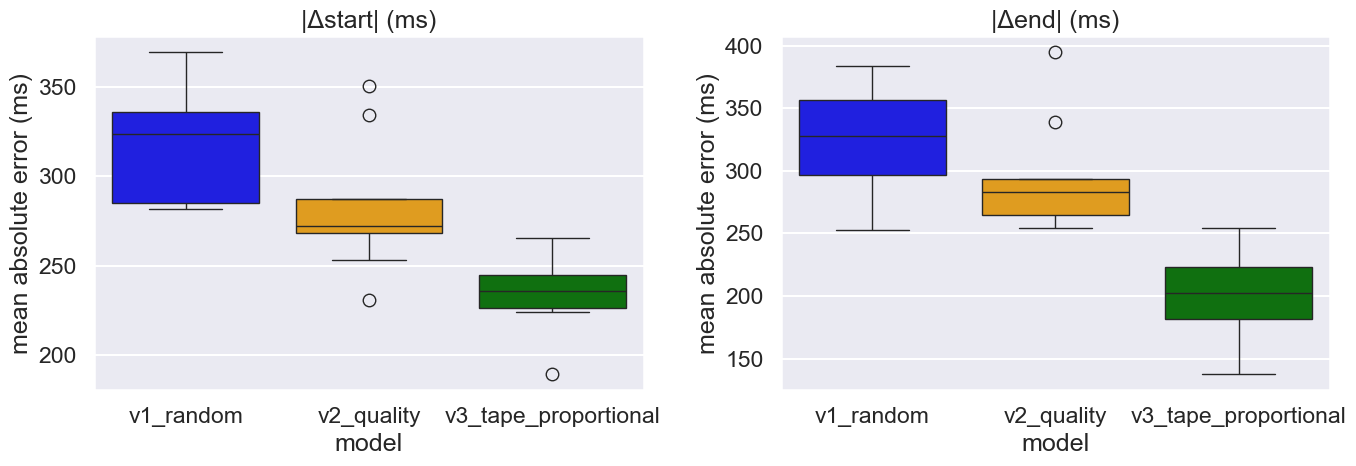

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom color palette and order
custom_palette = {
    "v1_random": "blue",
    "v2_quality": "orange",
    "v3_tape_proportional": "green",
}
model_order = ["v1_random", "v2_quality", "v3_tape_proportional"]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(
    x="model",
    y="mean_dstart_ms",
    data=df,
    ax=axs[0],
    palette=custom_palette,
    order=model_order
)
axs[0].set_title("|Δstart| (ms)")
axs[0].set_ylabel("mean absolute error (ms)")

sns.boxplot(
    x="model",
    y="mean_dend_ms",
    data=df,
    ax=axs[1],
    palette=custom_palette,
    order=model_order
)
axs[1].set_title("|Δend| (ms)")
axs[1].set_ylabel("mean absolute error (ms)")

plt.tight_layout()
plt.show()